In [1]:
# First, we need some basic imports:
import sys
import os
import time

import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

# add the proxpython directory into the Python's path
sys.path.append("./ProxPython")


## Magentic Resonance Imaging in the ProxToolbox

In this notebook, we are going to implement Magnetic Resonance Imaging (MRI) in the ProxToolbox, more specifically, we are going to implement it using projections.

As MRI is a quite a slow technique, a common approach for speeding it up is undersampling, so basically skipping e.g. every second or third line. As the data in Cartesian MRI is in Fourier domain, this would lead to infolding. To recover an unfolded image, additional information is used: As data is normally recorded by multiple receiver coils with overlapping but distinct regions of senstivity, this coil sensitivity information can be used to recover images without any infolding (see the orignal [SENSE paper](https://doi.org/10.1002/(SICI)1522-2594(199911)42:5<952::AID-MRM16>3.0.CO;2-S) or the [ESPIRiT paper](https://dx.doi.org/10.1002/mrm.24751) for different formulation that might be easier to understand).

### Sensitivity Encoding (SENSE)

As is common in 2D Cartesian MRI, our data consists of $N_y$ lines of $N_x$ samples each in Fourier-space (called k-space in MRI) for a number of coils $N_C$. Additionally, not sampled lines are simply set to zero, so that our k-space has the same x and y dimensions as our final image.

It is convenient to define the pattern $P$ as the the $N_x \times N_y$ array consisting of 1's at sampled locations and 0's at not sampled locations. 


In general, let $S_i$ be the coil sensitivity profile of the $i$th coil, let $y_i$ be the measured data in the $i$th coil, $\mathcal{F}$ be the Cartesian 2-Dimensional Fourier transform and $P$ the projection onto the acquired samples as defined above. Then, given a (complex) image $m$, we can write MRI as the following forward problem:

$$
  y_i = P\mathcal{F}S_im
$$

In order to use the ProxToolbox, we need to cast this problem as projections. The way we are going to do it here
is not by directly determining $m$, but by first reconstructing a complete k-space, and then calculating an image
by inverse Fourier transform and then combining the coil images. The canonical combination in MRI is the root-sum-of-squared of the coil images.

The first projection, data consistency, is pretty straigh-forward:

### Data consistency

With the above definitions, we simply take $u$ (our current estimate for the completed k-space), set it to zero at sampled locations by subtracting $Pu$, and adding the measured data $k \equiv Pk$ at those locations:
$P_{ds}u = u - Pu + Py$

In [2]:
from proxtoolbox.proxoperators.proxoperator import ProxOperator

class P_consis(ProxOperator):
    """
    Projection onto measured data:
    """
    def __init__(self, experiment):
        self.pat = experiment.pattern
        self.ksp = experiment.b

    def eval(self, u, prox_idx = None):
        return u - self.pat * u + self.pat * self.ksp 

### Projection onto the coil sensitivities

As our $u$ is in k-space but we have coil sensitivity profiles in image space, we need to transform $u$ before and after the application of the coil sensitivities. Note that, apart from the projection onto the pattern, adjoint followed by the forward of the forward problem defined above:

$P_{sens}u = \mathcal{F}SS^H\mathcal{F}^Hu$

For this, we first define centered, normed Fourier transforms using `numpy`s `fft` module:

In [3]:
def centered_fft(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.fftshift(x), axes=(0,1), norm='ortho'))

def centered_ifft(x):
    return np.fft.ifftshift(np.fft.ifftn(np.fft.ifftshift(x), axes=(0,1), norm='ortho'))

Then, the projection onto the coil sensitivity profiles can be written as follows.

In [4]:
class P_sens(ProxOperator):
    """
    Projection sensitivities
    """

    def __init__(self, experiment):
        self.sens = experiment.A

    def forw(self, im):
        return centered_fft(im * self.sens)

    def adj(self, k):
        return np.sum(np.conj(self.sens) * centered_ifft(k), axis=(2,), keepdims=True)

    def eval(self, u, prox_idx = None):
        ret = self.forw(self.adj(u))
        return ret

With this, we can start implementing the rest.

### ProxToolbox MRI Experiment
In the ProxToolbox, projections and proxoperators are just the lowest level. In general, the view is as follows:

We create an Experiment, which is a class defining the data, the model, the algorithm and the operators used to describe and solve some problem. For MRI, this is going to be the `MRI_Showcase` class.

We will define its default parameters, then implement its `loadData`-Method to load the (prepared) MRI data, set up the prox-operators (or in our case, the projections), and finally implement some convenience functions to actually produce images.

Note that comments here have to be interspersed with the code, as python does not allow the definition of a class in multiple cells.

In [5]:
from proxtoolbox.experiments.experiment import Experiment
from proxtoolbox.utils.graphics import addColorbar

class MRI_Showcase(Experiment): # Subclass Experiment here, so that we don't need to implement _everything_
    """
    MRI SENSE experiment class
    """

    @staticmethod
    def getDefaultParameters():
        defaultParams = {
            'experiment_name': 'MRI SENSE',
            'object': 'complex',
            'constraint': 'convex',
            'algorithm': 'AP',
            'MAXIT': 50,
            'TOL': -1e-6,
            'lambda_0': 0.85, # useful default for RAAR/DRl
            'lambda_max': 0.85,
            'data_ball': 1e-5,
            'diagnostic': False,
            'iterate_monitor_name': 'IterateMonitor',
            'rotate': False,
            'verbose': 0,
            'graphics': 1,
            'figure_width': 7,
            'figure_height': 7,
            'anim': True, # animate by default
            'debug': True
        }
        return defaultParams

    def __init__(self,
                 rescale = False,
                 dataname = 'phantom',
                 anim_slowdown = False,
                 **kwargs):
        """
        """
        # call parent's __init__ method
        super(MRI_Showcase, self).__init__(**kwargs)
        self.rescale = rescale
        self.dataname = dataname
        self.anim_slowdown = anim_slowdown

        # do here any data member initialization
        self.A = None
        self.b = None

# The loadData method. As we have prepared datasets in the `data/` directory, we can just load those with
# `np.load`

    def loadData(self):
        """
        Load MRI dataset and create the initial iterate (just all zeros in this case)
        """

        def load_ksp_sens_pat(name):
            ksp = np.load('data/' + name + '_ksp.npy')
            sens = np.load('data/' + name + '_sens.npy')
            pat = np.load('data/' + name + '_pat.npy')
            return ksp, sens, pat

        # Maybe not the best software engineering, but it gets the job done
        if self.dataname.startswith('phantom'):
            if not self.silent:
                print('Loading MRI Shepp-Logan data')
            ksp, sens, pat = load_ksp_sens_pat(self.dataname)
        elif self.dataname.startswith('knee'):
            if not self.silent:
                print('Loading MRI knee data')
            ksp, sens, pat = load_ksp_sens_pat(self.dataname)
        elif self.dataname.startswith('head'):
            if not self.silent:
                print('Loading MRI head data')
            ksp, sens, pat = load_ksp_sens_pat(self.dataname)


        # After squeezing, ksp will have size of (N_x, N_y, N_c), with the number of coils N_c
        ksp = ksp.squeeze()
        self.Nx = ksp.shape[0]
        self.Ny = ksp.shape[1]
        self.Nz = ksp.shape[2] # really N_c

        self.A = sens.reshape(self.Nx, self.Ny, self.Nz)
        self.b = ksp
        
        # Cannot work with 3D k-space:
        if self.b.ndim > 3:
            raise RuntimeError("Cannot handle 3D data for now")
        
        # add an extra dimension here so that numpy does the correct thing in the P_consis class:
        # Just multiply all elements together
        self.pattern = pat.reshape((self.Nx, self.Ny, 1))

        
        # The inital iterate. Just an array of zeros in our case.
        self.u0 = np.zeros_like(self.b)
        #self.u0 = np.ones_like(self.b)

        # The data norm. Could also be set to 1
        self.norm_data = np.linalg.norm(self.b)

        
# In this case, we are just using two operators: P_consis and P_sens as defined above. If you, for example,
# want to use a product space formulation of a problem, you can define them in the productProxOperators-array.
# If you do not define your own proxoperator-classes, you can also specify operators by their names as strings.

    def setupProxOperators(self):
        """
        Determine the prox operators to be used for this experiment
        """
        super(MRI_Showcase, self).setupProxOperators()  # call parent's method
        #self.productProxOperators = []

        self.proxOperators = []
        self.proxOperators.append(P_consis)
        self.proxOperators.append(P_sens)

        
# As we have already defined setupProxOperators, we do not need this here. If you use pre-defined operators
# from the ProxToolbox, you can refer to them by name as a string, and this method would retrieve the proper
# classe for you.

    def retrieveProxOperatorClasses(self):
        pass



# Using the operators we defined, we are reconstructing complete k-space data. To turn this
# into a single image, we take its Fourier transform, and them calculate the root-sum-squares of the
# individual coil images
    @staticmethod
    def u2im(u):
        tmp = centered_ifft(u)
        return np.sqrt(np.sum(np.abs(tmp)**2, axis=(2,), keepdims=True))

    def postprocess(self):
        self.solution = self.u2im(self.output['u'])

        
        
# Most of the postprocessing is just taken from the CT example and slightly adapted. It basically
# shows the current iterate and log of iterate difference to judge convergence.
    def show(self):

        u = self.output['u']

        if u.ndim == 2:
            u = u[:,0]


        u = self.u2im(u).squeeze()

        # figure(900)
        f, (ax1, ax2) = plt.subplots(2, 1,
                                                figsize=(self.figure_width, self.figure_height),
                                                dpi=self.figure_dpi)
        self.createImageSubFigure(f, ax1, u, 'best approx')

        changes = self.output['stats']['changes']
        time = self.output['stats']['time']
        time_str = "{:.{}f}".format(time, 5) # 5 is precision
        xLabel = "Iterations (time = " + time_str + " s)"
        algo_desc = self.algorithm.getDescription()
        title = "Algorithm " + algo_desc
        ax2.plot(changes)
        ax2.set_yscale('log')
        ax2.set_xlabel(xLabel)
        ax2.set_ylabel('log of iterate difference')
        ax2.set_title(title)

        plt.show()

    def animate(self, alg):
        """
        Display animation. This method is called
        after each iteration of the algorithm `alg` if
        data member `anim` is set to True.

        Parameters
        ----------
        alg : instance of Algorithm class
            Algorithm that is running.
        """
        # the output is a picture in a column vector
        if alg.u_new is not None:
            u = alg.u_new
        else:  # this the case when called before algorithm runs
            u = alg.u
        if u.ndim == 2:
            u = u[:,0]

        if self.anim_slowdown:
            time.sleep(0.1)
        image = self.u2im(u).squeeze()
        title = "Iteration " + str(alg.iter)
        self.animateFigure(image, title)


    def createImageSubFigure(self, f, ax, u, title = None):
        im = ax.imshow(u, cmap='gray')
        addColorbar(im)
        if title is not None:
            ax.set_title(title)

            


### Running our new experiment
Now that we have defined our experiment class, we can instantiate an object of call `.run()` and `.show()` on it.
And since we have cast this problem in the structure used in the ProxToolbox, we get access to all of the different projection-based algorithms that are available!

Loading MRI head data
Running DRl on MRI SENSE...


<IPython.core.display.Javascript object>


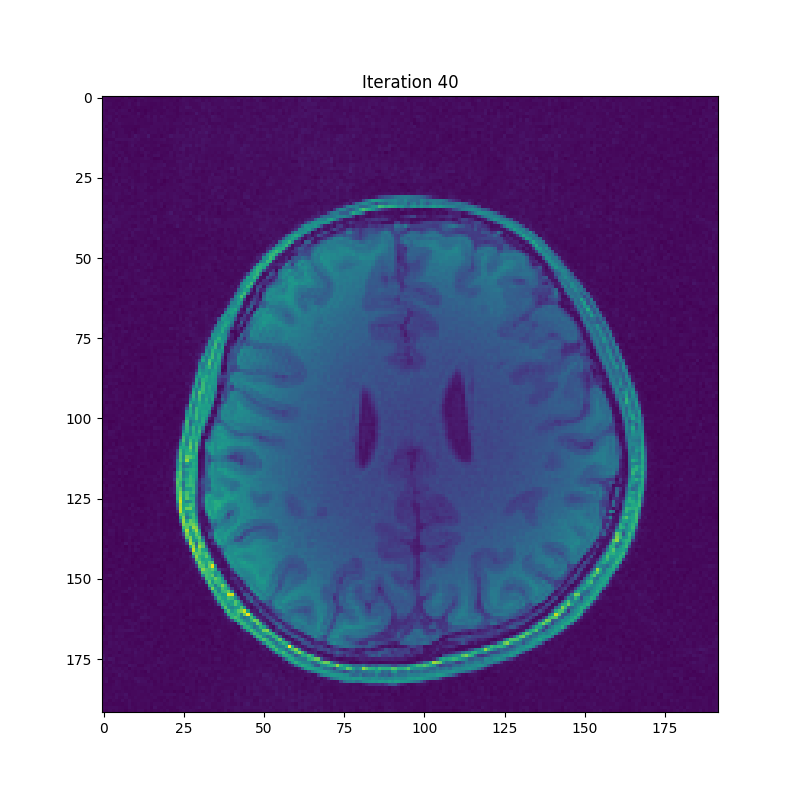

Took 40 iterations and 15.983540534973145 seconds.


In [6]:
# We can choose different example datasets
#data='knee'
data='head'
#data='phantom'

# 0.85 seems like a good default for RAAR (= DRl)
lambda_ = 0.85
MAXIT=40

######## Choose your algorithm ########

algo='DRl' # relaxed Douglas-Rachford or Relaxed Averaged Alternating Reflections
#algo='AP' # Alternating Projections
#algo='AvP' # Averaged Projections
#algo='DRAP' # hybrid of Douglas-Rachford and Alternating projections

MRI_exp = MRI_Showcase(algorithm=algo, MAXIT=MAXIT, anim=True, anim_step=1,
                       dataname=data, lambda_0=lambda_, lambda_max=lambda_,)
MRI_exp.run()



<IPython.core.display.Javascript object>


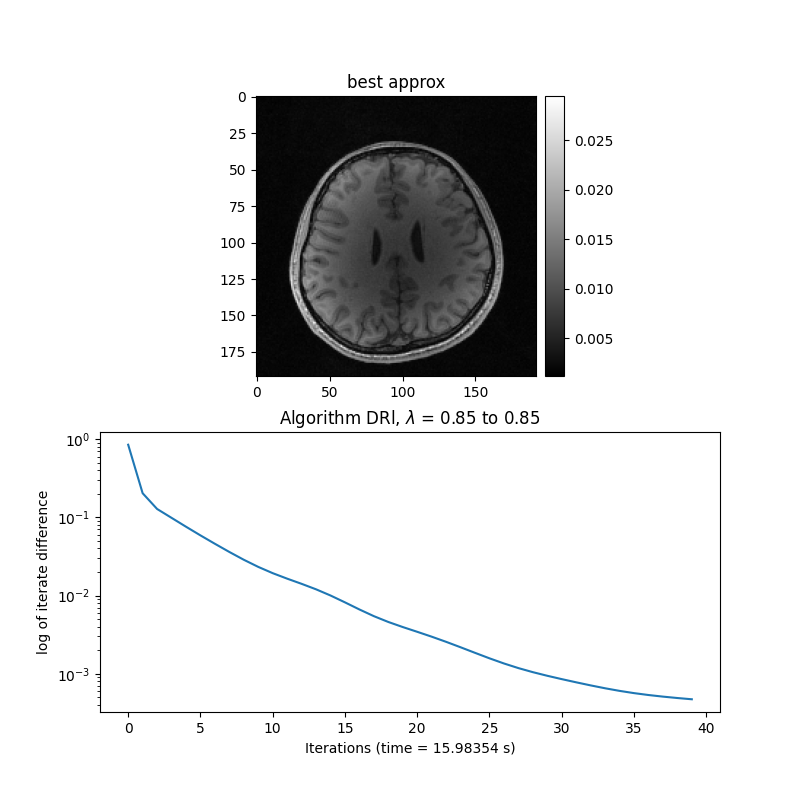

In [7]:
MRI_exp.show()

And now we are free to experiment, using e.g. different algorithms and showing their difference:

Loading MRI head data
Running AP on MRI SENSE...


<IPython.core.display.Javascript object>


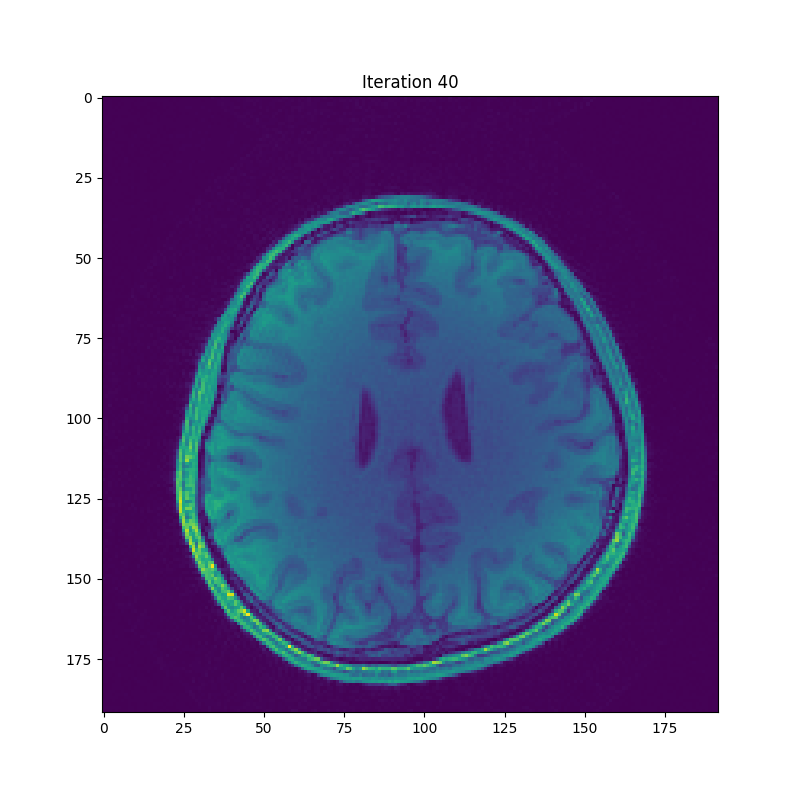

Took 40 iterations and 14.032679080963135 seconds.


In [8]:
MRI_exp_AP = MRI_Showcase(algorithm='AP', MAXIT=MAXIT, anim=True, anim_step=1,
                       dataname=data, lambda_0=lambda_, lambda_max=lambda_,)
MRI_exp_AP.run()

<IPython.core.display.Javascript object>


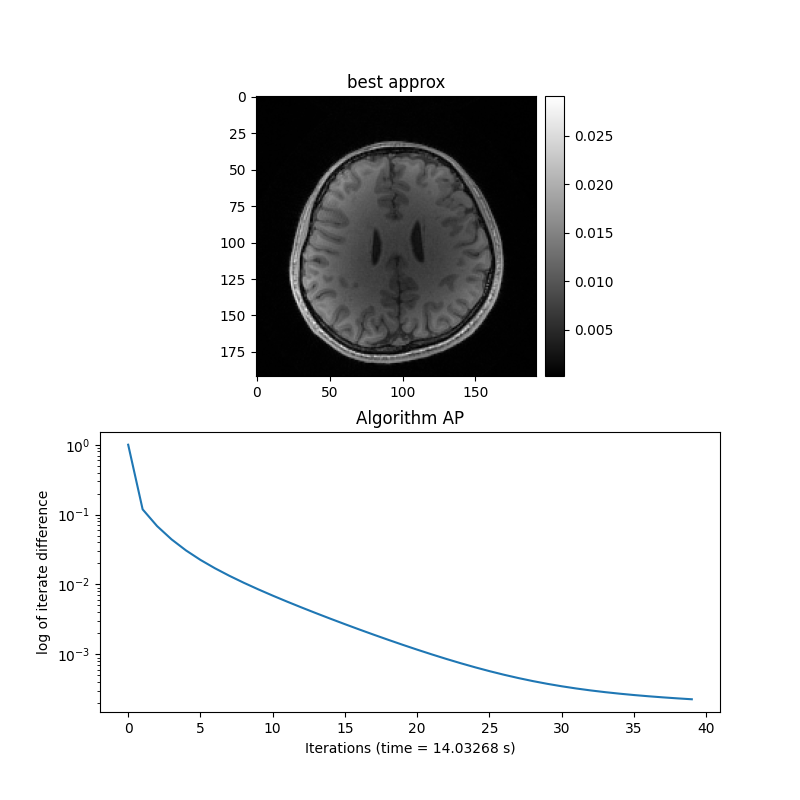

In [9]:
MRI_exp_AP.show()

In [10]:
# Let's calculate the normalized root-mean-squre error
diff = np.abs(MRI_exp.solution - MRI_exp_AP.solution).squeeze()
nrmse = np.sum(np.abs(diff)**2)/np.sum(np.abs(MRI_exp.solution)**2)
print('NRMSE: ', nrmse)

NRMSE:  0.025510205754476992


<IPython.core.display.Javascript object>


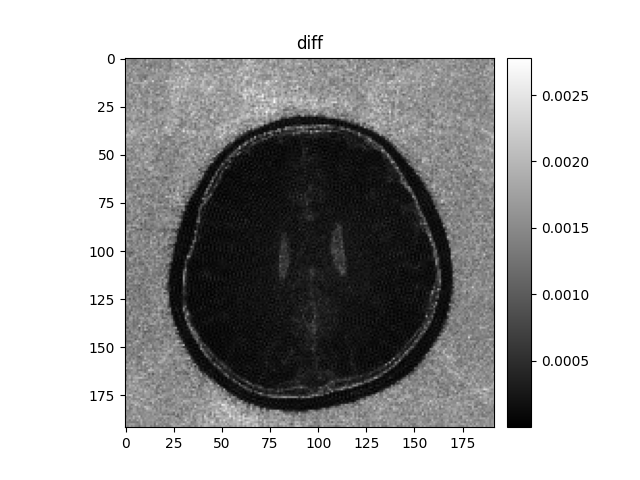

In [11]:
# and plot the difference
f, ax = plt.subplots(1,1)
MRI_exp.createImageSubFigure(f, ax, diff, "diff")
plt.show()